In [3]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

CUDA is available. Using GPU.


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
from torch.utils.data import DataLoader, Dataset

file_path = 'disease_symptoms_diagnosis.csv'
df = pd.read_csv(file_path)
df['combined_text'] = df['disease'] + " [SEP] " + df['diagnosis']

train_df, test_df = train_test_split(df, test_size=0.1)

class GPT2Dataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

MAX_LEN = 256
BATCH_SIZE = 4

train_dataset = GPT2Dataset(train_df['combined_text'].tolist(), tokenizer, MAX_LEN)
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

test_dataset = GPT2Dataset(test_df['combined_text'].tolist(), tokenizer, MAX_LEN)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

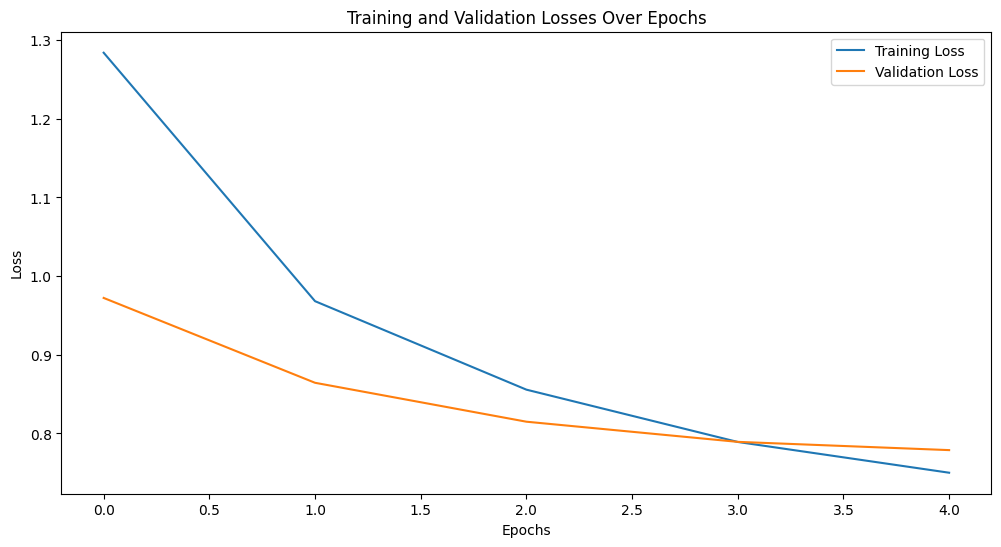

Epoch 5/5, Train Loss: 0.750056282776158, Val Loss: 0.7787893338081164


In [5]:
from transformers import AdamW, get_linear_schedule_with_warmup
from matplotlib import pyplot as plt
from IPython.display import clear_output

model = GPT2LMHeadModel.from_pretrained('gpt2')
model = model.to('cuda')

optimizer = AdamW(model.parameters(), lr=5e-5)
NUM_EPOCHS = 5
total_steps = len(train_data_loader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    for batch in train_data_loader:
        input_ids, attention_mask = [x.to(device) for x in batch]

        outputs = model(input_ids, labels=input_ids, attention_mask=attention_mask)
        loss = outputs.loss

        total_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_data_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_data_loader:
            input_ids, attention_mask = [x.to(device) for x in batch]

            outputs = model(input_ids, labels=input_ids, attention_mask=attention_mask)
            loss = outputs.loss

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_data_loader)
    val_losses.append(avg_val_loss)

    clear_output(wait=True)
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

torch.save(model.state_dict(), "disease2diagnosis_gpt2_fine-tuned.pth")

In [9]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GPT2LMHeadModel.from_pretrained('gpt2')
model_path = 'disease2diagnosis_gpt2_fine-tuned.pth'  # 替换为你的模型文件路径
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)

input_text = "Psoriasis"
input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
attention_mask = torch.ones(input_ids.shape, dtype=torch.long, device=device)

output = model.generate(
    input_ids,
    attention_mask=attention_mask, 
    max_length=100,
    pad_token_id=tokenizer.eos_token_id,
    num_return_sequences=1
)

generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Psoriasis [SEP] Based on your description, it seems like you may be experiencing a skin condition called psoriasis. Psoriasis is a chronic autoimmune disease that affects the skin, causing redness, itching, and inflammation. It can also lead to skin sensitivity and sensitivity to light.  To manage psoriasis, there are several treatment options available. Topical corticosteroids such as hydrocortisone cream or hydrocortisone cream can help reduce inflammation
